In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import norm

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns*math.sqrt(abs(nu)/time)
        self.pose = IdealRobot.state_transition(pnu, time, self.pose)
        
    def observation_update(self, observation): 
        print(observation)

In [3]:
class Mcl:  
    def __init__(self, init_pose, num, motion_noise_stds=0.15):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        
        self.motion_noise_rate_pdf = norm(loc=0.0, scale=motion_noise_stds)
        
    def motion_update(self, nu, time):
        for p in self.particles:
            p.motion_update(nu, time, self.motion_noise_rate_pdf)
    
    def observation_update(self, observation):   #メソッド追加
        for p in self.particles:
            p.observation_update(observation)
   
    def draw(self, ax, elems): 
        xs = [p.pose for p in self.particles]
        ys = [0] * len(self.particles)
        vxs = [0.1] * len(self.particles) 
        vys = [0] * len(self.particles) 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent): 
    def __init__(self, time_interval, nu, estimator): 
        super().__init__(nu)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        
    def decision(self, observation=None): #追加
        self.estimator.motion_update(self.prev_nu, self.time_interval)
        self.prev_nu = self.nu
        self.estimator.observation_update(observation)
        return self.nu
    
    def draw(self, ax, elems):  
        self.estimator.draw(ax, elems)

<IPython.core.display.Javascript object>


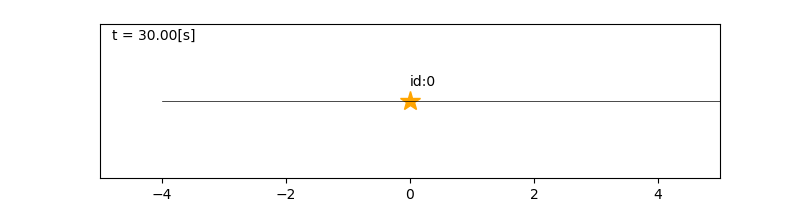

In [5]:
time_interval = 0.1
world = World(30, 0.1)  

m = Map()
m.append_landmark(Landmark(0))

world.append(m)          

### ロボットを作る ###
initial_pose = -4
estimator = Mcl(initial_pose, 100)
straight = EstimationAgent(time_interval, 0.5, estimator) 
r = Robot(initial_pose, sensor=Camera(m), agent=straight) 
world.append(r)

### アニメーション実行 ###
world.draw()

